Celem ninejszego notatnika jest zaprezentowanie porównania wyników PCA na zbiorze ,,wine'' w porównaniu z wynikami uzyskanymi dzięki vae i vanilla autoencoder. 

In [1]:
from data_helper import get_dataloaders_and_standarscaler_photons
from train_helper import train_vae
from plot_helper import plot_training_loss

import copy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Hyperparameters
RANDOM_SEED = 123
LEARNING_RATE = 0.0005
BATCH_SIZE = 512
NUM_EPOCHS = 20
LOGGING_INTERVAL=500
path='photons.npy'

In [3]:
CUDA_DEVICE_NUM=0
DEVICE = torch.device(f'cuda:{CUDA_DEVICE_NUM}' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)

Device: cpu


In [4]:
#ODCZYTANIE DANYCH Z PLIKU 'photons.npy'
photons = np.load(path)
X = np.zeros(photons.shape,dtype=np.float32)
np.copyto(X,photons)

In [5]:
df_data = pd.DataFrame(X, columns = ['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df_data.head()#zawsze warto rzucić okiem na dane

,X,Y,dX,dY,dZ,E
0,0.42000,1.05666,-5.14814,0.040652,-0.198063,0.979346
1,0.26173,-1.74098,-4.74566,0.052218,-0.303938,0.951260
2,0.39096,1.24705,4.90818,0.019018,0.337769,0.941037
3,0.42000,2.54507,-3.28148,0.098677,-0.127226,0.986953
4,0.42000,1.33431,-4.38559,0.051587,-0.169556,0.984170


In [6]:
train_loader, valid_loader, test_loader, stdcs = get_dataloaders_and_standarscaler_photons(path=path,
    batch_size=BATCH_SIZE, 
    num_workers=0,
    test_fraction=0.2, 
    validation_fraction=0.0)

In [7]:
#TWORZENIE ITERATORA PRZYDATNEGO W PĘTLI UCZĄCEJ MODELU
dataiter_train=iter(train_loader)
data_train=dataiter_train.next()
features_train = data_train

print(features_train.shape)

#TWORZENIE ITERATORA ZBIORU TESTOWEGO 
dataiter_test=iter(test_loader)
data_test=dataiter_test.next()
features_test = data_test


torch.Size([512, 6])


In [8]:
#MODEL NASZEJ SIECI 13->13->7->3
class VAE_Linear(nn.Module):
    def __init__(self):
        super().__init__()        
        self.encoder = nn.Sequential(
            nn.Linear(6, 4),
            #nn.BatchNorm1d(5),
            nn.ReLU(),
            # nn.Linear(5, 4),
            nn.BatchNorm1d(4),
            # nn.ReLU(),
        )

        self.z_mean=nn.Sequential(
            torch.nn.Linear(4,3),
            #nn.BatchNorm1d(3),
            #nn.ReLU(),
            #nn.Linear(3,3)
            )

        self.z_log_var=nn.Sequential(
            torch.nn.Linear(4,3),
           # nn.BatchNorm1d(3),
            #nn.ReLU(),
            #nn.Linear(3,3)
            )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 4),
            nn.ReLU(),
            nn.BatchNorm1d(4),
            # nn.Linear(4,5),
            # nn.ReLU(),
            #nn.BatchNorm1d(5),
            nn.Linear(4,6)
            
           # nn.Sigmoid()
        )
    def reparameterize(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to(z_mu.get_device())#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def reparameterize_for_cpu(self, z_mu, z_log_var):
        eps = torch.randn(z_mu.size(0), z_mu.size(1)).to('cpu')#get_device dziala tylko dla tensoróœ z gpu
        z = z_mu + eps * torch.exp(z_log_var/2.) 
        return z

    def forward(self, x):
        x = self.encoder(x)
        z_mean, z_log_var = self.z_mean(x), self.z_log_var(x)
        encoded = self.reparameterize_for_cpu(z_mean, z_log_var)
        decoded = self.decoder(encoded)
        return encoded, z_mean, z_log_var, decoded

In [9]:
model = VAE_Linear()
model.to(DEVICE)

#criterion = nn.MSELoss()#FUNKCJA STRATY
optimizer = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE, 
                             weight_decay=1e-5)

In [10]:
log_dict=train_vae(num_epochs=NUM_EPOCHS, device=DEVICE, model=model,optimizer=optimizer,train_loader=train_loader,loss_fn=None, test_loader=test_loader, logging_interval=LOGGING_INTERVAL, reconstruction_term_weight=250)

Epoch: 001/020 | Batch 0000/1555 | Loss: 1415.5095
Epoch: 001/020 | Batch 0500/1555 | Loss: 352.7905
Epoch: 001/020 | Batch 1000/1555 | Loss: 48.3862
Epoch: 001/020 | Batch 1500/1555 | Loss: 23.3573
***Epoch: 001/020 | Loss: 0.076
Test***Epoch: 001/020 | Loss: 0.076
Time elapsed: 0.39 min
Epoch: 002/020 | Batch 0000/1555 | Loss: 22.6633
Epoch: 002/020 | Batch 0500/1555 | Loss: 18.4464
Epoch: 002/020 | Batch 1000/1555 | Loss: 18.9639
Epoch: 002/020 | Batch 1500/1555 | Loss: 16.7857
***Epoch: 002/020 | Loss: 0.051
Test***Epoch: 002/020 | Loss: 0.051
Time elapsed: 0.76 min
Epoch: 003/020 | Batch 0000/1555 | Loss: 15.8389
Epoch: 003/020 | Batch 0500/1555 | Loss: 15.1433
Epoch: 003/020 | Batch 1000/1555 | Loss: 14.6727
Epoch: 003/020 | Batch 1500/1555 | Loss: 13.4855
***Epoch: 003/020 | Loss: 0.043
Test***Epoch: 003/020 | Loss: 0.043
Time elapsed: 1.12 min
Epoch: 004/020 | Batch 0000/1555 | Loss: 13.8047
Epoch: 004/020 | Batch 0500/1555 | Loss: 12.0649
Epoch: 004/020 | Batch 1000/1555 | Los

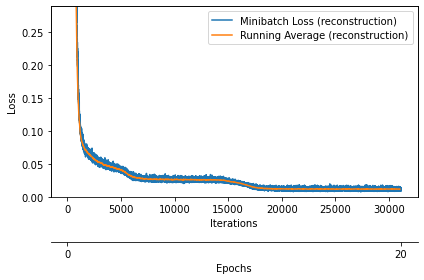

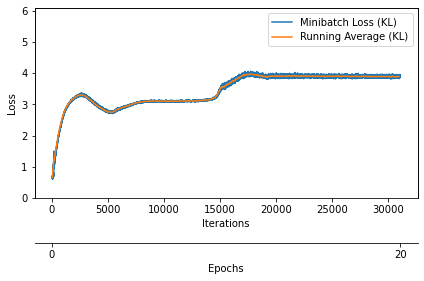

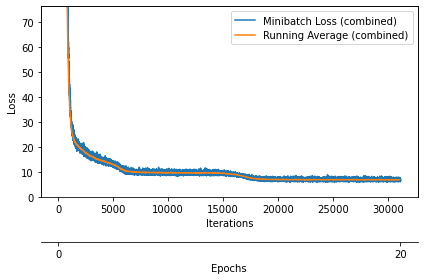

In [11]:
plot_training_loss(log_dict['train_reconstruction_loss_per_batch'], NUM_EPOCHS, custom_label=" (reconstruction)")
plot_training_loss(log_dict['train_kl_loss_per_batch'], NUM_EPOCHS, custom_label=" (KL)")
plot_training_loss(log_dict['train_combined_loss_per_batch'], NUM_EPOCHS, custom_label=" (combined)")
plt.show()



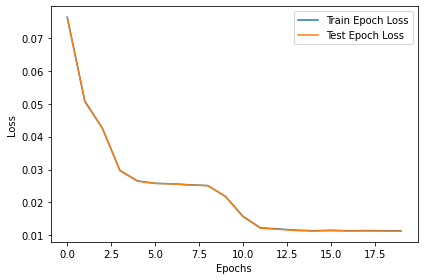

In [12]:
plt.plot(range(len(log_dict['train_combined_loss_per_epoch'])), (log_dict['train_combined_loss_per_epoch']), label='Train Epoch Loss')
plt.plot(range(len(log_dict['test_combined_loss_per_epoch'])), (log_dict['test_combined_loss_per_epoch']), label='Test Epoch Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim(0.15,0.3)
plt.tight_layout()

In [13]:
tmp=df_data.to_numpy(dtype=np.float32)
orginal=copy.deepcopy(tmp)
tmp=stdcs.transform(tmp)
tmp=torch.from_numpy(tmp)
#print(tmp)
with torch.no_grad():
    result_encoded_features, z_mean, z_log_var, result_decoded_features =model(tmp.to(device=DEVICE))
result=result_decoded_features.cpu().detach().numpy()
result=stdcs.inverse_transform(result)

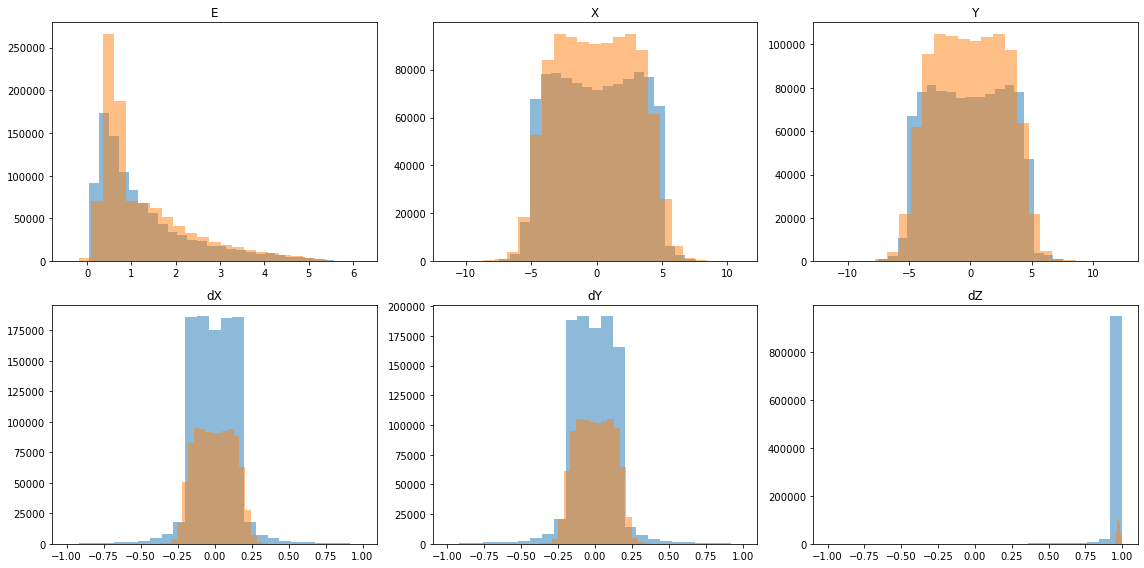

In [14]:
fig, axs = plt.subplots(2, 3)
fig.set_size_inches(16,8)
axs[0, 0].hist(orginal[:,0],bins=25, label ='orginal',alpha=0.5)
axs[0, 0].hist(result[:,0],bins=25, label ='encoded', alpha=0.5)
axs[0, 0].set_title('E')
axs[0, 1].hist(orginal[:,1],bins=25, label ='orginal',alpha=0.5)
axs[0, 1].hist(result[:,1],bins=25, label ='encoded', alpha=0.5)
axs[0, 1].set_title('X')
axs[0, 2].hist(orginal[:,2],bins=25, label ='orginal',alpha=0.5)
axs[0, 2].hist(result[:,2],bins=25, label ='encoded', alpha=0.5)
axs[0, 2].set_title('Y')
axs[1, 0].hist(orginal[:,3],bins=25, label ='orginal',alpha=0.5)
axs[1, 0].hist(result[:,3],bins=25, label ='encoded', alpha=0.5)
axs[1, 0].set_title('dX')
axs[1, 1].hist(orginal[:,4],bins=25, label ='orginal',alpha=0.5)
axs[1, 1].hist(result[:,4],bins=25, label ='encoded', alpha=0.5)
axs[1, 1].set_title('dY')
axs[1, 2].hist(orginal[:,5],bins=25, label ='orginal',alpha=0.5)
axs[1, 2].hist(result[:,5],bins=25, label ='encoded', alpha=0.5)
axs[1, 2].set_title('dZ')

# for ax in axs.flat:
#     ax.set(xlabel='x-label', ylabel='y-label')

# # Hide x labels and tick labels for top plots and y ticks for right plots.
# for ax in axs.flat:
#     ax.label_outer()
fig.tight_layout()

In [15]:
decoded_df=pd.DataFrame(result,columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
orginal_df=df_data.iloc[:,1:]


concatenated_datasets=pd.concat([orginal_df.assign(dataset_name='orginal'), decoded_df.assign(dataset_name='decoded')],ignore_index=True)
concatenated_datasets.shape
print(concatenated_datasets.index.is_unique)

True


/home/jakub/anaconda3/envs/WithPytorch/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


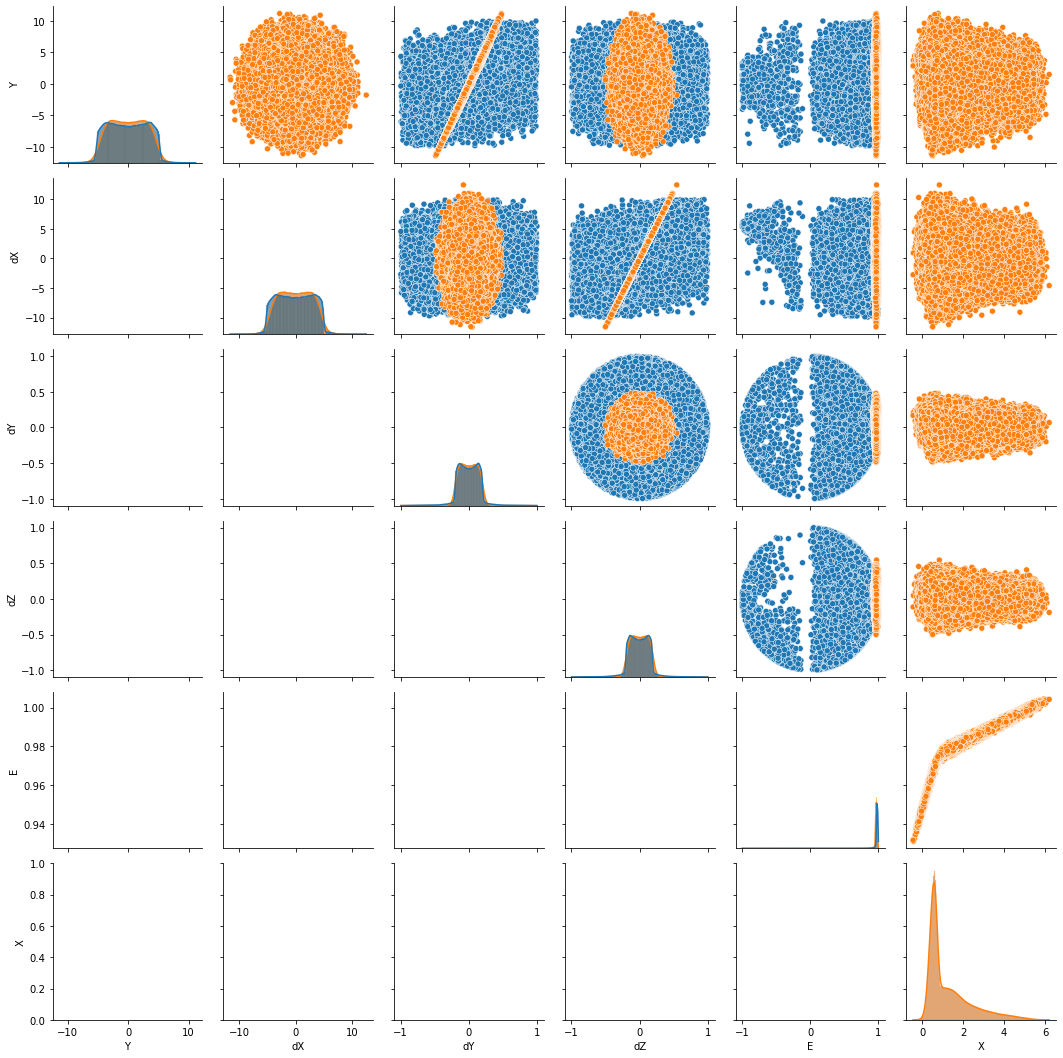

In [16]:
g = sns.PairGrid(concatenated_datasets, hue='dataset_name')
g.map_upper(sns.scatterplot)
#g.map_lower(sns.kdeplot, fill=True)
g.map_diag(sns.histplot, kde=True)

In [17]:
#sns.pairplot(concatenated_datasets, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5),corner=True)


In [18]:
#trzeba by sprawdzić czy to losowanie działa poprawnie i zwraca próbkę reprezentatywną
sample=concatenated_datasets.groupby('dataset_name', group_keys=False).apply(lambda x: x.sample(frac=0.0005, random_state=2)) 
print(sample.shape)
print(sample.head())

(996, 7)
                Y        dX        dY        dZ         E dataset_name  \
1174565 -2.076254  1.162488 -0.093001  0.055098  0.976416      decoded   
1609424  1.082372 -2.934436  0.048407 -0.123373  0.968968      decoded   
1539655  2.117665  2.401119  0.101775  0.109369  0.962087      decoded   
1506954  1.268222 -0.096133  0.049698 -0.000394  0.975106      decoded   
1855494  3.490413 -3.583607  0.145685 -0.151065  0.982416      decoded   

                X  
1174565  1.018995  
1609424  0.563246  
1539655  0.415166  
1506954  0.752986  
1855494  1.983233  


/home/jakub/anaconda3/envs/WithPytorch/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


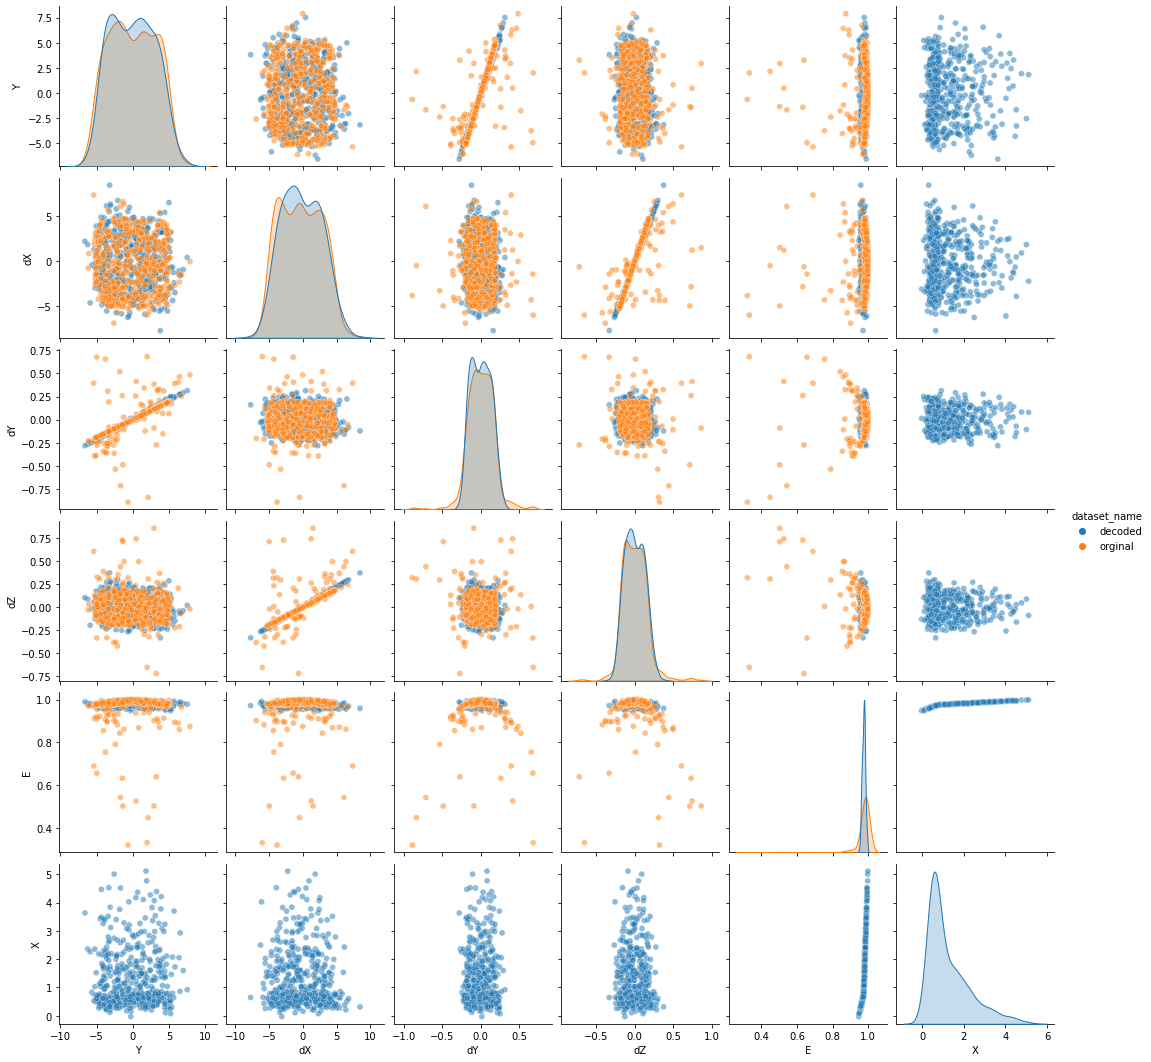

In [19]:
sns.pairplot(sample, hue="dataset_name", kind="scatter", plot_kws=dict(alpha=0.5))

In [20]:
tmp_2=df_data.iloc[37:38,:]
tmp_2=tmp_2.to_numpy(dtype=np.float32)
orginal_2=tmp_2
tmp_2=stdcs.transform(tmp_2)
tmp_2=torch.from_numpy(tmp_2)
with torch.no_grad():
    result_encoded_features_2, z_mean_2, z_log_var_2, result_decoded_features_2=model(tmp_2.to(device=DEVICE))
result_2=result_decoded_features_2.cpu().detach().numpy()
result_2=stdcs.inverse_transform(result_2)

In [21]:
orginal_2=orginal_2.flatten()
result_2=result_2.flatten()

In [22]:
df=pd.DataFrame(np.stack((orginal_2,result_2)), columns=['X', 'Y', 'dX', 'dY', 'dZ', 'E'])
df

,X,Y,dX,dY,dZ,E
0,2.061480,0.760660,-2.516470,0.029714,-0.098330,0.994710
1,2.027273,1.821655,-1.641293,0.074610,-0.066276,0.982497


In [23]:
encoded_features=[]
for index, feature in enumerate(train_loader):
    with torch.no_grad():
        tmp_encoded_features, z_mean, z_log_var, decoded =model(feature.to(device=DEVICE))
        encoded_features.extend(tmp_encoded_features.cpu().detach().numpy())
encoded_features=np.asarray(encoded_features)

print(encoded_features.shape)

(796160, 3)


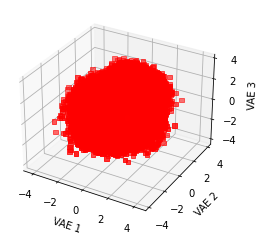

In [24]:
#PRZESTRZEŃ UKRYTA VAE
colors = ['r']
markers = ['s']

fig=plt.figure()
ax=fig.add_subplot(projection='3d')
for c, m in zip(colors, markers):
    ax.scatter(encoded_features[:,0],encoded_features[:,1],encoded_features[:,2],marker=m,c=c)

ax.set_xlabel('VAE 1')
ax.set_ylabel('VAE 2')
ax.set_zlabel('VAE 3')

plt.show()